# project about NBA stat #4
https://www.kaggle.com/datasets/mharvnek/nba-team-stats-00-to-18 

מגישים- איתן מוצפי, יונתן סלוצקי, שי דוידוביץ ויאיר בר חי

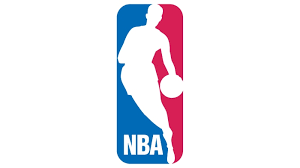

## יבוא הקובץ

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [2]:
url='https://github.com/eytanmuzafi/data-science/raw/main/nba_team_stats_00_to_21.csv'
nba_stat= pd.read_csv(url)

## בדיקת בעיות וחריגות בדאטה

In [3]:
nba_stat.isnull().sum()

teamstatspk    0
TEAM           0
GP             0
W              0
L              0
WIN%           0
MIN            0
PTS            0
FGM            0
FGA            0
FG%            0
3PM            0
3PA            0
3P%            0
FTM            0
FTA            0
FT%            0
OREB           0
DREB           0
REB            0
AST            0
TOV            0
STL            0
BLK            0
BLKA           0
PF             0
PFD            0
+/-            0
SEASON         0
dtype: int64

In [4]:
nba_stat.dtypes

teamstatspk      int64
TEAM            object
GP               int64
W                int64
L                int64
WIN%           float64
MIN            float64
PTS            float64
FGM            float64
FGA            float64
FG%            float64
3PM            float64
3PA            float64
3P%            float64
FTM            float64
FTA            float64
FT%            float64
OREB           float64
DREB           float64
REB            float64
AST            float64
TOV            float64
STL            float64
BLK            float64
BLKA           float64
PF             float64
PFD            float64
+/-            float64
SEASON          object
dtype: object

SEASON היא אובייקט.

נעדיף לא לשנות אותו לסוג דייט טיים כדי להשאיר את זה בצורה הזאת, כי עונה מתפרסת על שני חצאי שנה ולא על שנה מלאה.

In [5]:
len(nba_stat)

626

## בדיקת מספר הקבוצות

ראינו שמספר השורות לא מתחלק בשלושים, וידוע לנו שבכל עונה צריכות להיות שלושים קבוצות.

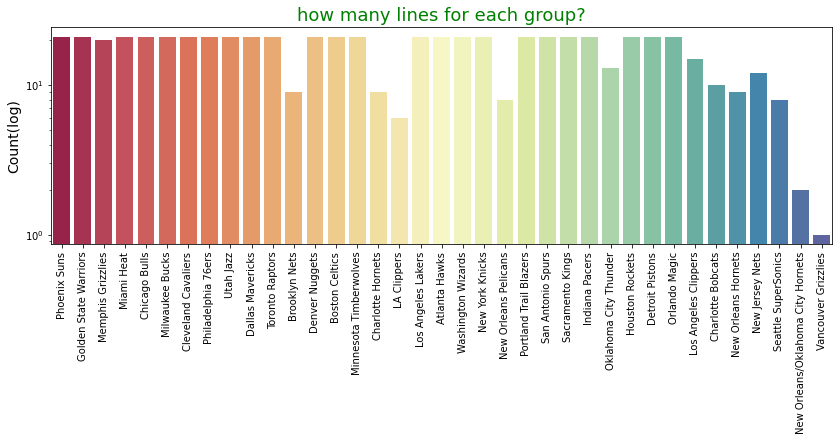

In [6]:
plt.figure(figsize=(14,4)) 
ax=sns.countplot( x = 'TEAM', data = nba_stat,palette="Spectral")
ax.set_yscale("log")
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Count(log)",fontsize=14)
ax.set_xlabel("")
ax.set_title("how many lines for each group?",color='green',fontsize=18);

ידוע לנו שמספר הקבוצות צריך להיות 30. יש קבוצות שהחליפו את שמם, אז נשנה בהתאם.

In [7]:
nba_stat.set_index('TEAM', inplace=True)
nba_stat.rename(index = {"LA Clippers": "Los Angeles Clippers",
                     "Seattle SuperSonics":"Oklahoma City Thunder","New Jersey Nets": "Brooklyn Nets",
                     "Charlotte Bobcats":"Charlotte Hornets","New Orleans Hornets": "New Orleans Pelicans","New Orleans/Oklahoma City Hornets": "New Orleans Pelicans"},
                                 inplace = True)

In [8]:
nba_stat=nba_stat.reset_index()

In [9]:
len(nba_stat.TEAM.unique())

31

בדקנו באינטרנט ומצאנו-
שארלוט הצטרפה בעונת  2004-5 והחליפה את ונקובר ולכן המספר לא מתחלק בשלושים.
לכן נוריד את העונות עד שהיא הצטרפה.


In [10]:
nba_stat=nba_stat[nba_stat['SEASON']>='2004-05'].copy()
len(nba_stat)

510

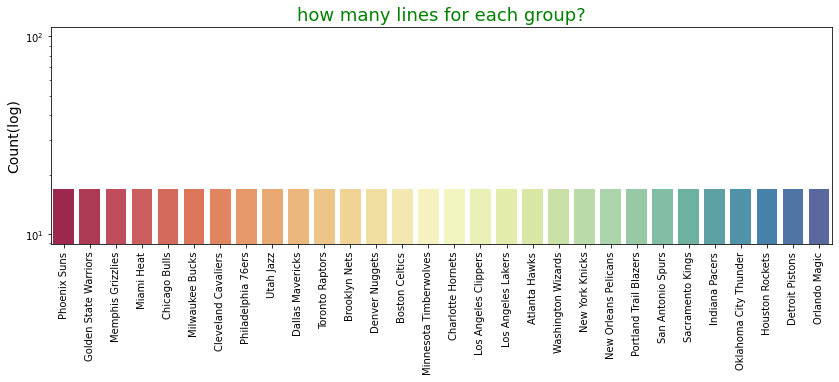

In [11]:
plt.figure(figsize=(14,4)) 
ax=sns.countplot( x = 'TEAM', data = nba_stat,palette="Spectral")
ax.set_yscale("log")
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Count(log)",fontsize=14)
ax.set_xlabel("")
ax.set_title("how many lines for each group?",color='green',fontsize=18);

## סידור עמודות ובדיקת חריגות

יש 3 סוגי זריקות. זריקות לשלוש נקודות, שתי נקודות, ולנקודה אחת.

קיימת קטגוריה של זריקות מהשדה, סוג זה כולל את הזריקות לשתי נקודות, ואת הזריקות לשלוש נקודות.

ראינו שחסרה עמודה של כמות זריקות לשתי נקודות, ושל כמות הקליעות לשתי נקודות. ניצור כאלה כדי שיהיה יותר נוח ונוריד עמודות מיותרות.

In [12]:
nba_stat['FGM']=nba_stat['FGM']-nba_stat['3PM']
nba_stat['FGA']=nba_stat['FGA']-nba_stat['3PA']
nba_stat = nba_stat.rename(columns={'FGM':'2PM','FGA':'2PA'})
nba_stat['FG%']=nba_stat['2PM']/nba_stat['2PA']
nba_stat = nba_stat.rename(columns={'FG%':'2P%'})

In [13]:
nba_stat.drop(labels='teamstatspk',axis=1,inplace=True)

In [14]:
nba_stat.columns

Index(['TEAM', 'GP', 'W', 'L', 'WIN%', 'MIN', 'PTS', '2PM', '2PA', '2P%',
       '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', '+/-', 'SEASON'],
      dtype='object')

נבדוק אם יש חריגות בתחומים בכל קטגוריה

In [15]:
features = ['TEAM', 'GP', 'W', 'L', 'WIN%', 'MIN', 'PTS', '2PM',
       '2PA', '2P%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB',
       'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', '+/-']
melted_nba_stat= pd.melt(nba_stat[features], id_vars = 'TEAM', value_vars = features)

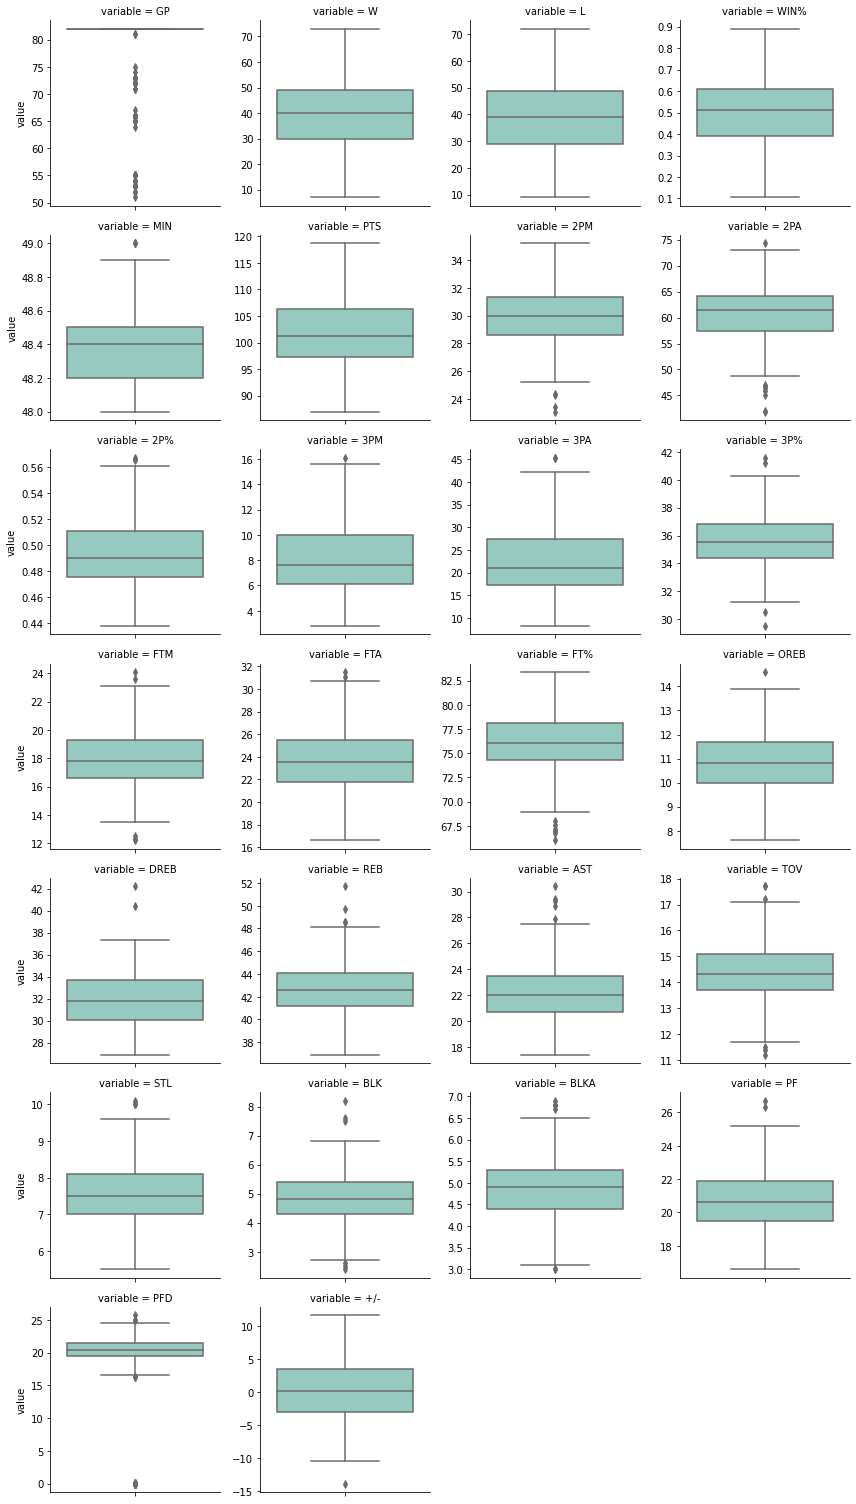

In [16]:
ans = sns.FacetGrid(data = melted_nba_stat, col="variable",  col_wrap=4,sharey=False)
ans.map_dataframe(sns.boxplot, y = 'value',palette='Set3');

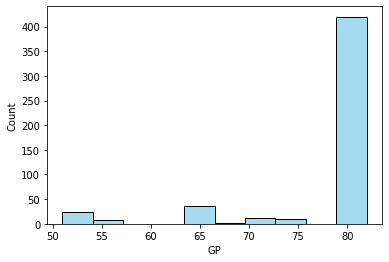

In [17]:
sns.histplot( x = 'GP', data = nba_stat,color='skyblue');

במדד זה קיימת חריגה בגלל שבעונה האחרונה שוחקו פחות משחקים בגלל הקורונה. לכן בכל החישובים נעשה בדיקה לפי אחוזי נצחונות

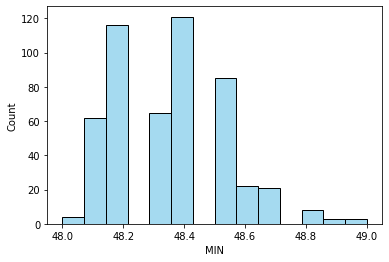

In [18]:
sns.histplot( x = 'MIN', data = nba_stat ,color='skyblue');

למרות שיש בכל משחק 48 דקות, יש משחקים עם יותר בגלל הארכות וזה גם כן בסדר.

נוריד את מדד המשחקים ואת מדד הדקות בכל משחק, כי אין בהן נתונים שנרצה להשתמש בהם

In [19]:
nba_stat.drop(labels=['MIN','GP'],axis=1,inplace=True)

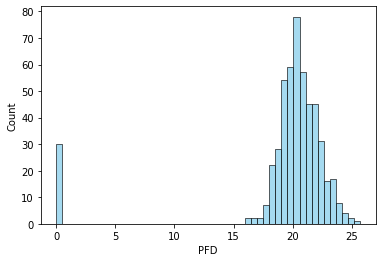

In [20]:
sns.histplot( x = 'PFD', data = nba_stat,color='skyblue');

 מדד זה מודד את כמות העבירות שנעשתה על הקבוצה בממוצע למשחק

In [21]:
nba_stat[nba_stat.PFD==0].SEASON

480    2004-05
481    2004-05
482    2004-05
483    2004-05
484    2004-05
486    2004-05
487    2004-05
490    2004-05
491    2004-05
492    2004-05
494    2004-05
495    2004-05
496    2004-05
497    2004-05
498    2004-05
499    2004-05
500    2004-05
501    2004-05
503    2004-05
506    2004-05
507    2004-05
508    2004-05
509    2004-05
Name: SEASON, dtype: object

מדובר על עונה אחת. אם נרצה להשתמש בעמודה זו נזכור שיש בה חריגה ונטפל בהתאם לשימוש בה.

In [22]:
nba_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 0 to 509
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEAM    510 non-null    object 
 1   W       510 non-null    int64  
 2   L       510 non-null    int64  
 3   WIN%    510 non-null    float64
 4   PTS     510 non-null    float64
 5   2PM     510 non-null    float64
 6   2PA     510 non-null    float64
 7   2P%     510 non-null    float64
 8   3PM     510 non-null    float64
 9   3PA     510 non-null    float64
 10  3P%     510 non-null    float64
 11  FTM     510 non-null    float64
 12  FTA     510 non-null    float64
 13  FT%     510 non-null    float64
 14  OREB    510 non-null    float64
 15  DREB    510 non-null    float64
 16  REB     510 non-null    float64
 17  AST     510 non-null    float64
 18  TOV     510 non-null    float64
 19  STL     510 non-null    float64
 20  BLK     510 non-null    float64
 21  BLKA    510 non-null    float64
 22  PF

## חיפוש קורלציות


נבדוק איזה סוג ההתלפגות כדי לדעת באיזה מקדם מתאם להשתמש

In [23]:
features = ['TEAM', 'WIN%','PTS', '2PM','2PA', '2P%', '3PM',
        '3PA', '3P%','FTM', 'FTA', 'FT%', 'OREB', 'DREB',
       'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', '+/-']
melted_nba_stat_corr= pd.melt(nba_stat[features], id_vars = 'TEAM', value_vars = features)

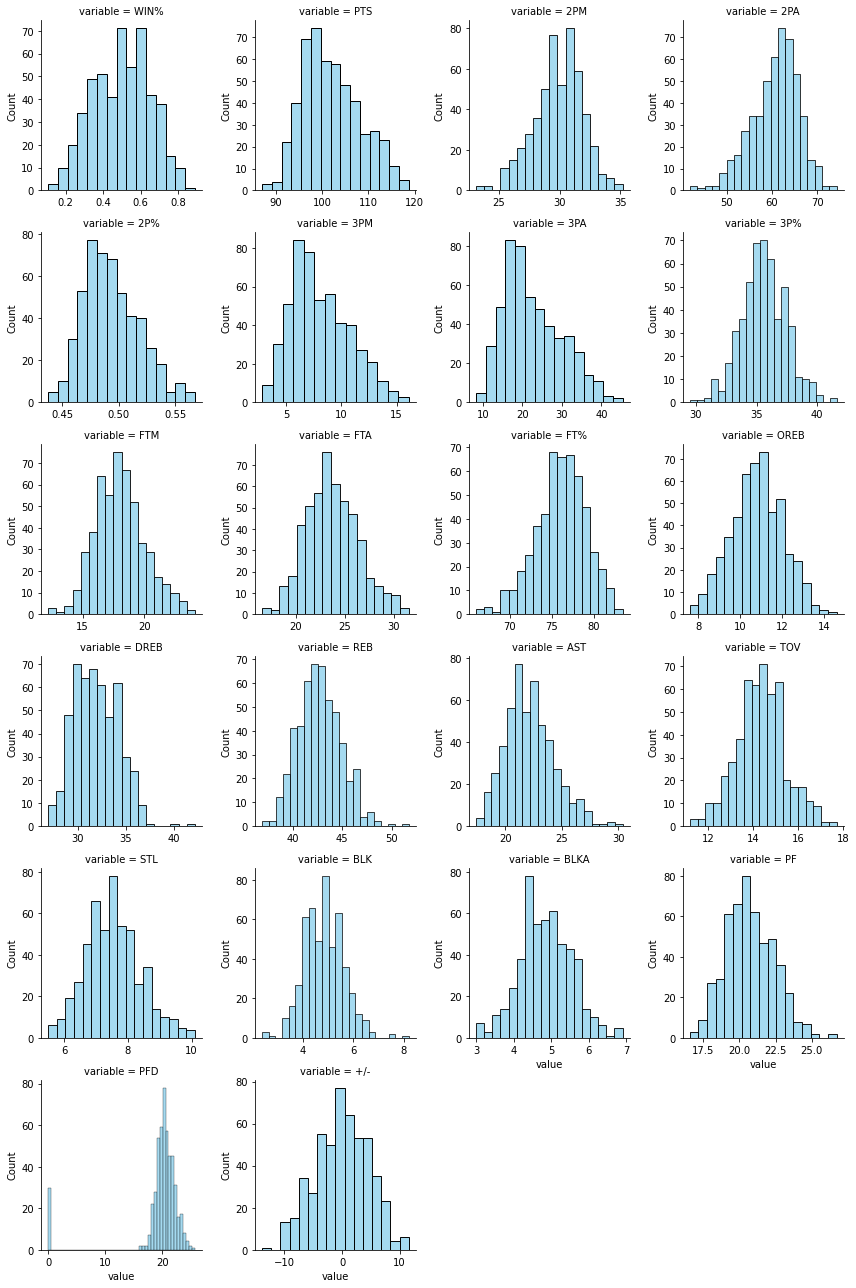

In [24]:
ans = sns.FacetGrid(data = melted_nba_stat_corr, col="variable",  col_wrap=4,sharey=False,sharex=False)
ans.map_dataframe(sns.histplot, x = 'value',color = 'skyblue');

In [25]:
nba_stat_cut=nba_stat[['TEAM', 'WIN%', 'PTS', '2PM',
       '2PA', '2P%', '3PM', '3PA', '3P%', 'FTM','FTA', 'FT%','REB', 'AST','BLK', 'BLKA', 'PF', 'PFD', '+/-']]

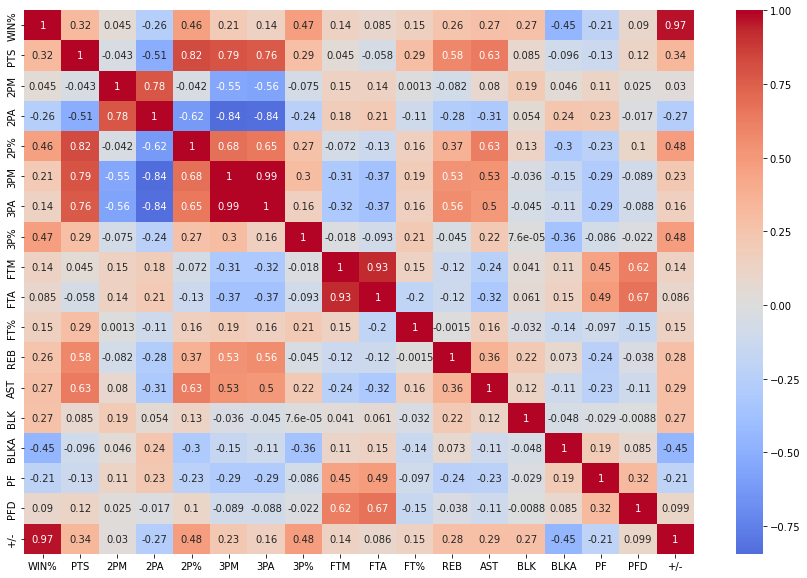

In [26]:
corrs = nba_stat_cut.corr(method = 'spearman')
plt.figure(figsize=(15,10)) 
sns.heatmap(corrs, cmap='coolwarm', center=0, annot = True);

 ## מפת קורלציות מצומצמת מסקנה 1

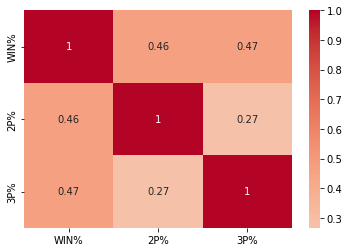

In [27]:
corrs = nba_stat[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(6,4)) 
sns.heatmap(corrs, cmap='coolwarm', center=0, annot = True);

היינו מצפים שיהיה מתאם יותר גבוה בין קליעה לנצחון ככל שהקליעה שווה יותר נקודות. אבל להפתעתנו רואים כי דווקא יש מתאם דומה בין אחוזי קליעה לשתיים ונצחונות, לבין אחוזי קליעה לשלוש ונצחונות.
מעניין לבדוק אם יש שינוי בין תקופות בליגה.

##### בדיקה איזה תקופות דומות 

<AxesSubplot:>

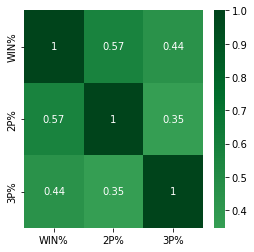

In [28]:
nba_2004=nba_stat[(nba_stat['SEASON']=='2004-05')] 
corrs = nba_2004[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

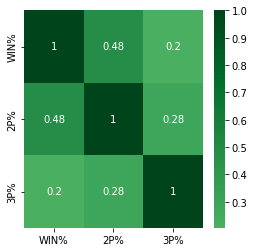

In [29]:
nba_2005=nba_stat[(nba_stat['SEASON']=='2005-06')] 
corrs = nba_2005[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

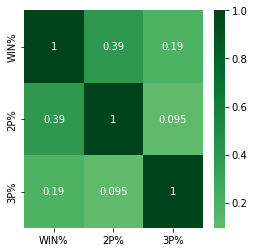

In [30]:
nba_2006=nba_stat[(nba_stat['SEASON']=='2006-07')] 
corrs = nba_2006[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

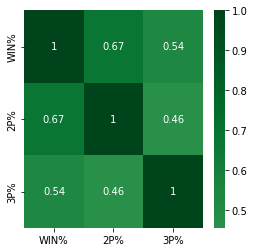

In [31]:
nba_2007=nba_stat[(nba_stat['SEASON']=='2007-08')] 
corrs = nba_2007[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

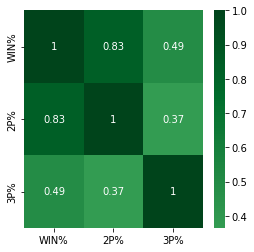

In [32]:
nba_2008=nba_stat[(nba_stat['SEASON']=='2008-09')] 
corrs = nba_2008[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

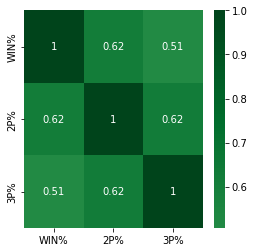

In [33]:
nba_2009=nba_stat[(nba_stat['SEASON']=='2009-10')]
corrs = nba_2009[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

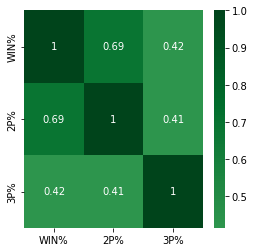

In [34]:
nba_2010=nba_stat[(nba_stat['SEASON']=='2010-11')] 
corrs = nba_2010[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

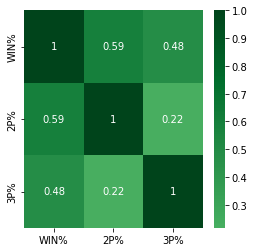

In [35]:
nba_2011=nba_stat[(nba_stat['SEASON']=='2011-12')] 
corrs = nba_2011[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

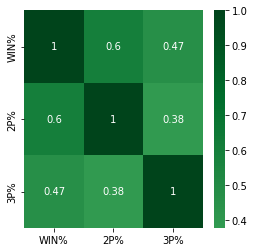

In [36]:
nba_2012=nba_stat[(nba_stat['SEASON']=='2012-13')] 
corrs = nba_2012[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

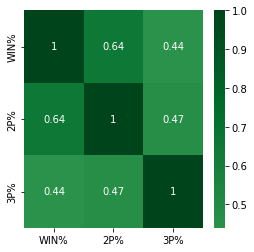

In [37]:
nba_2013=nba_stat[(nba_stat['SEASON']=='2013-14')] 
corrs = nba_2013[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

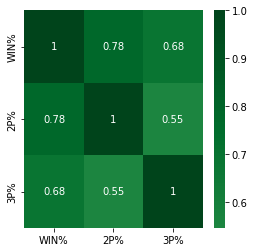

In [38]:
nba_2014=nba_stat[(nba_stat['SEASON']=='2014-15')] 
corrs = nba_2014[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

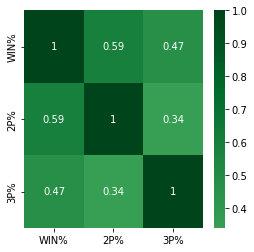

In [39]:
nba_2015=nba_stat[(nba_stat['SEASON']=='2015-16')] 
corrs = nba_2015[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

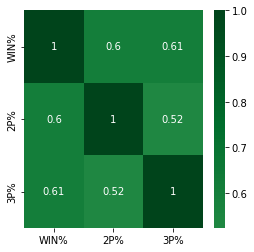

In [40]:
nba_2016=nba_stat[(nba_stat['SEASON']=='2016-17')] 
corrs = nba_2016[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

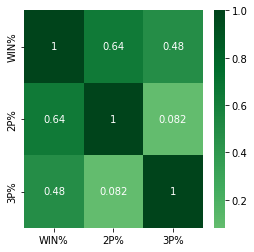

In [41]:
nba_2017=nba_stat[(nba_stat['SEASON']=='2017-18')] 
corrs = nba_2017[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

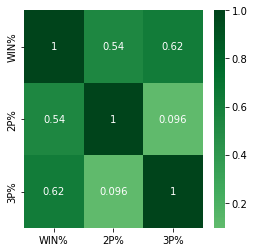

In [42]:
nba_2018=nba_stat[(nba_stat['SEASON']=='2018-19')] 
corrs = nba_2018[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

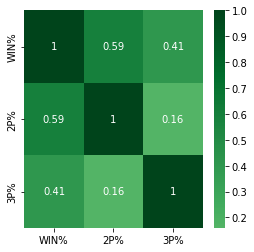

In [43]:
nba_2019=nba_stat[(nba_stat['SEASON']=='2019-20')] 
corrs = nba_2019[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

<AxesSubplot:>

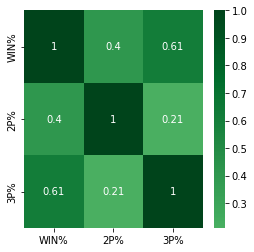

In [44]:
nba_2020=nba_stat[(nba_stat['SEASON']=='2020-21')] 
corrs = nba_2020[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='Greens', center=0, annot = True)

In [45]:
corr_2p_df = {'SEASON': ['2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020'],'corr':[0.57,0.48,0.39,0.67,0.83,0.62,0.69,0.59,0.6,0.64,0.78,0.59,0.6,0.64,0.54,0.59,0.4]}
corr_2p_df = pd.DataFrame(data=corr_2p_df)

In [46]:
corr_3p_df = {'SEASON': ['2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020'],'corr':[0.44,0.2,0.19,0.54,0.49,0.51,0.42,0.48,0.47,0.44,0.68,0.47,0.61,0.48,0.62,0.41,0.61]}
corr_3p_df = pd.DataFrame(data=corr_3p_df)

## גרף שמראה את השינוי בקורלציות בשנים

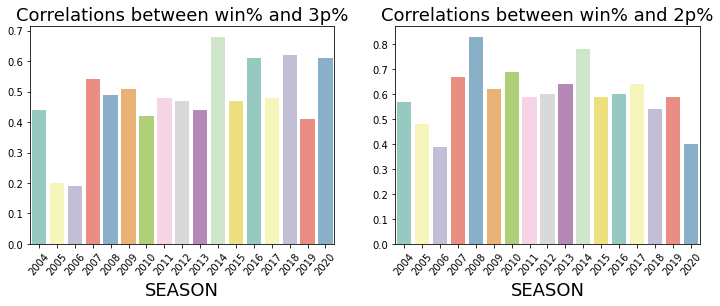

In [47]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].tick_params(axis='x', labelrotation=50)
axes[1].tick_params(axis='x', labelrotation=50)
sns.barplot(data=corr_3p_df,x='SEASON',y='corr',ax=axes[0],palette="Set3")
sns.barplot(data=corr_2p_df,x='SEASON',y='corr',ax=axes[1],palette="Set3")
axes[0].set_title("Correlations between win% and 3p%",fontsize=18)
axes[0].set_xlabel('SEASON',fontsize=18)
axes[0].set_ylabel("")
axes[1].set_title("Correlations between win% and 2p%",fontsize=18)
axes[1].set_xlabel('SEASON',fontsize=18)
axes[1].set_ylabel("")
plt.show()

##### התקופות המצומצמות שמהן נסיק את המסקנה

<AxesSubplot:>

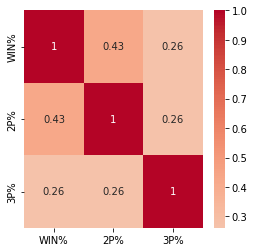

In [48]:
nba_to_2006=nba_stat[nba_stat['SEASON']<='2006-07']
corrs = nba_to_2006[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='coolwarm', center=0, annot = True)

<AxesSubplot:>

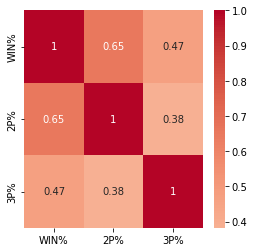

In [49]:
nba_from_2007_to_2013=nba_stat[(nba_stat['SEASON']>='2007-08') & (nba_stat['SEASON']<='2013-14')]
corrs = nba_from_2007_to_2013[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='coolwarm', center=0, annot = True)

<AxesSubplot:>

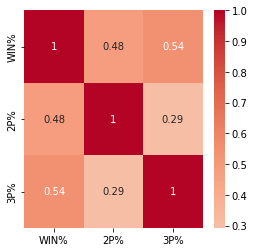

In [50]:
nba_from_2014=nba_stat[(nba_stat['SEASON']>='2014-15')]
corrs = nba_from_2014[['WIN%','2P%','3P%']].corr(method = 'spearman')
plt.figure(figsize=(4,4)) 
sns.heatmap(corrs, cmap='coolwarm', center=0, annot = True)

In [51]:
corr_df = {'Priod':['2004-2006','2007-2013','2014-2020'],'3p_corr':[0.26,0.47,0.54],'2p_corr':[0.43,0.65,0.48]}
corr_df = pd.DataFrame(data=corr_df)
corr_df

,Priod,3p_corr,2p_corr
0,2004-2006,0.26,0.43
1,2007-2013,0.47,0.65
2,2014-2020,0.54,0.48


## גרף להצגה מסקנה 1

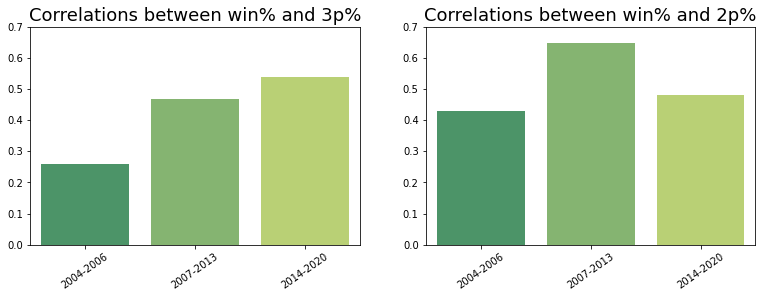

In [52]:
fig, axes = plt.subplots(1,2,figsize=(13,4))
axes[0].tick_params(axis='x', labelrotation=35)
axes[1].tick_params(axis='x', labelrotation=35)
sns.barplot(data=corr_df,x='Priod',y='3p_corr',ax=axes[0],palette='summer')
axes[0].set(ylim=(0, 0.7))
axes[0].set_title("Correlations between win% and 3p%",fontsize=18)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
sns.barplot(data=corr_df,x='Priod',y='2p_corr',ax=axes[1],palette='summer')
axes[1].set(ylim=(0, 0.7))
axes[1].set_title("Correlations between win% and 2p%",fontsize=18)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
plt.show()

בגרף האחוזים לשלוש ניתן לראות כי עם השנים המתאם בין אחוזי ניצחונות לאחוזי קליעה לשלוש גדל.

מנגד- ניתן לראות כי בגרף האחוזים לשתיים ישנן מגמות של עליה וירידה אבל לא מגמות ברורות .. 

## מסקנה 2 

נחפש שינויים שקורים בקטגוריות מסוימות בדאטה עם השנים, לראות מגמות שהכדורסל האמריקאי הולך אליהן.

In [53]:
features = ['SEASON','PTS', '2PM','2PA', '2P%', '3PM',
        '3PA', '3P%','FTM', 'FTA', 'FT%', 'OREB', 'DREB',
       'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD']
melt_nba_stat= pd.melt(nba_stat[features], id_vars = 'SEASON', value_vars = features)

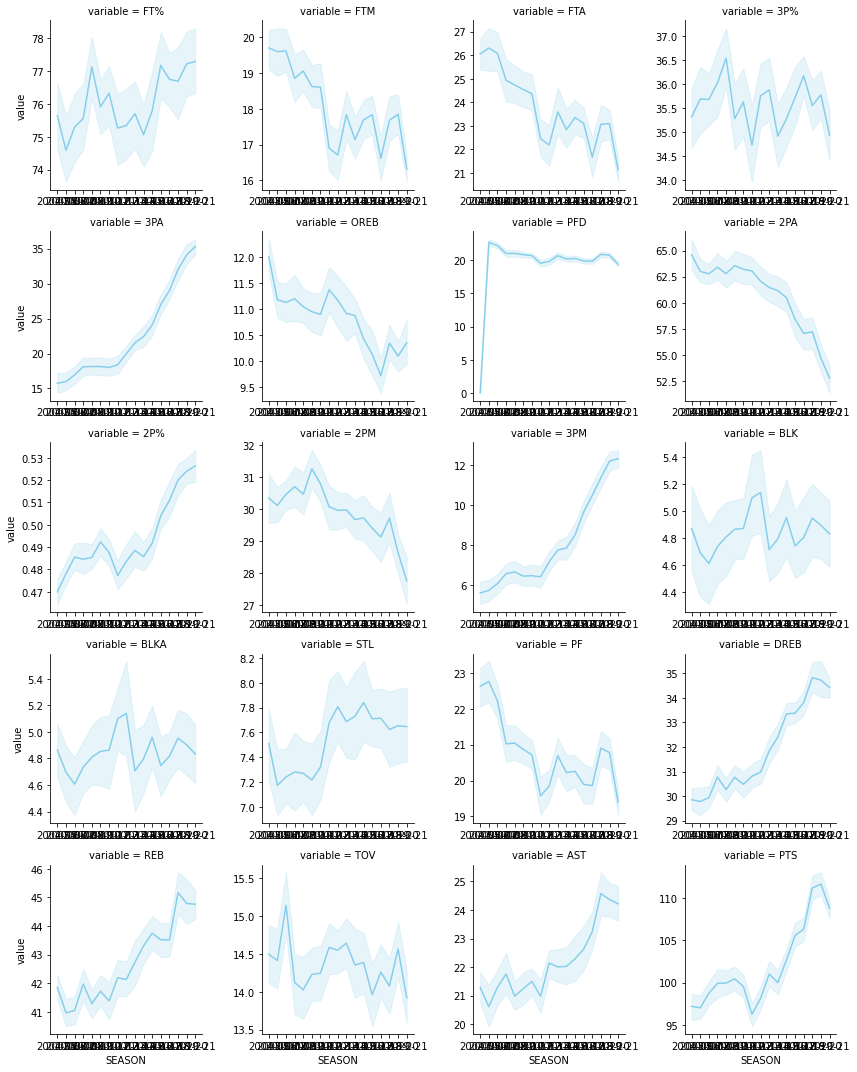

In [54]:
ans = sns.FacetGrid(data = melt_nba_stat.sort_values('SEASON'), col="variable",col_wrap=4,sharey=False,sharex=False)
ans.map_dataframe(sns.lineplot,x='SEASON', y = 'value',color='skyblue');

## גרף להצגת מסקנה 2

ניתן לראות שרוב המדדים ההתקפיים עולים, ורוב המדדים ההגנתיים יורדים ככל שעוברות השנים.
ננסה להראות את זה בצורה יותר בהירה, וניצור מדד התקפי, ומדד הגנתי.

In [55]:
nba_stat['def']=nba_stat['STL']+nba_stat['BLK']+nba_stat['PF']
nba_stat['off']=nba_stat['PTS']+nba_stat['2PM']+nba_stat['3PM']+nba_stat['AST']+nba_stat['FTM']

במדד ההתקפי- קליעות, נקודות ואסיסטים בממוצע לעונה.

במדד ההגנתי-חטיפות, חסימות, ועבירות. שמראות על אגרסיביות של הקבוצה בהגנה.

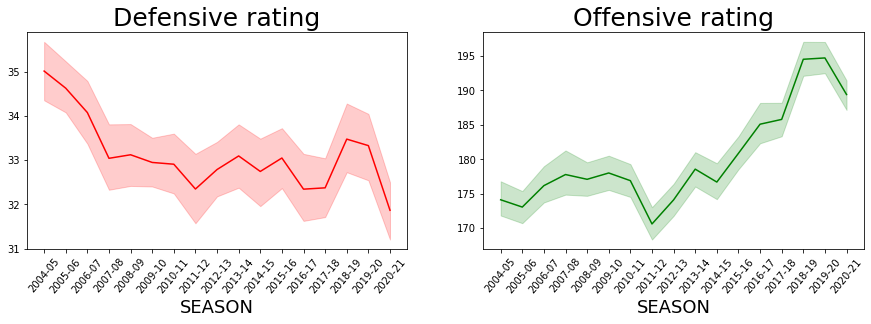

In [56]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
sns.lineplot(data=nba_stat.sort_values('SEASON'),x='SEASON',y='def',ax=axes[0],color='red')
sns.lineplot(data=nba_stat.sort_values('SEASON'),x='SEASON',y='off',ax=axes[1],color='green')
axes[0].tick_params(axis='x', labelrotation=50)
axes[1].tick_params(axis='x', labelrotation=50)
axes[1].set_title("Offensive rating",fontsize=25)
axes[0].set_title("Defensive rating",fontsize=25)
axes[0].set_ylabel("")
axes[0].set_xlabel('SEASON',fontsize=18)
axes[1].set_ylabel("")
axes[1].set_xlabel('SEASON',fontsize=18)
plt.show()

ניתן לראות כי לאורך השנים קיימת עליה במדד ההתקפי, ולעומת זאת ירידה במדד ההגנתי.

ההשוואה היא לא בין המדדים, אלא זיהוי מגמה בכל מדד בפני עצמו. ולכן המספרים בציר האנכי לא משנים את ההסתכלות על הגרף אלא משמשים להבנת המגמה.

## מסקנה 3

נחפש לראות האם יש קטגוריות מסויימות שמאפיינות את הקבוצות ברבעון העליון של הנצחונות בליגה

ניצור 2 מדדים נוספים (בנוסף לשני המדדים ממסקנה 2) שיכול להיות שיציגו הבדלים בין הרבעון העליון, לשאר הקבוצות.

In [57]:
nba_stat['throw']=nba_stat['2PA']+nba_stat['3PA']+nba_stat['FTA']
nba_stat['more posetion']=nba_stat['OREB']+nba_stat['STL']-nba_stat['TOV']

המדד הראשון סופר את כמות הזריקות שהקבוצה זורק בממוצע למשחק בעונה.

המדד השני סופר את כמות הפוזשנים שהקבוצה מוסיפה לעצמה בממוצע למשחק בעונה

In [58]:
nba_stat['WIN%'].describe()

count    510.000000
mean       0.499729
std        0.152183
min        0.106000
25%        0.390000
50%        0.512000
75%        0.610000
max        0.890000
Name: WIN%, dtype: float64

In [59]:
best_teams = nba_stat[nba_stat['WIN%']>=0.61].copy()
loser= nba_stat[nba_stat['WIN%']<0.61].copy()

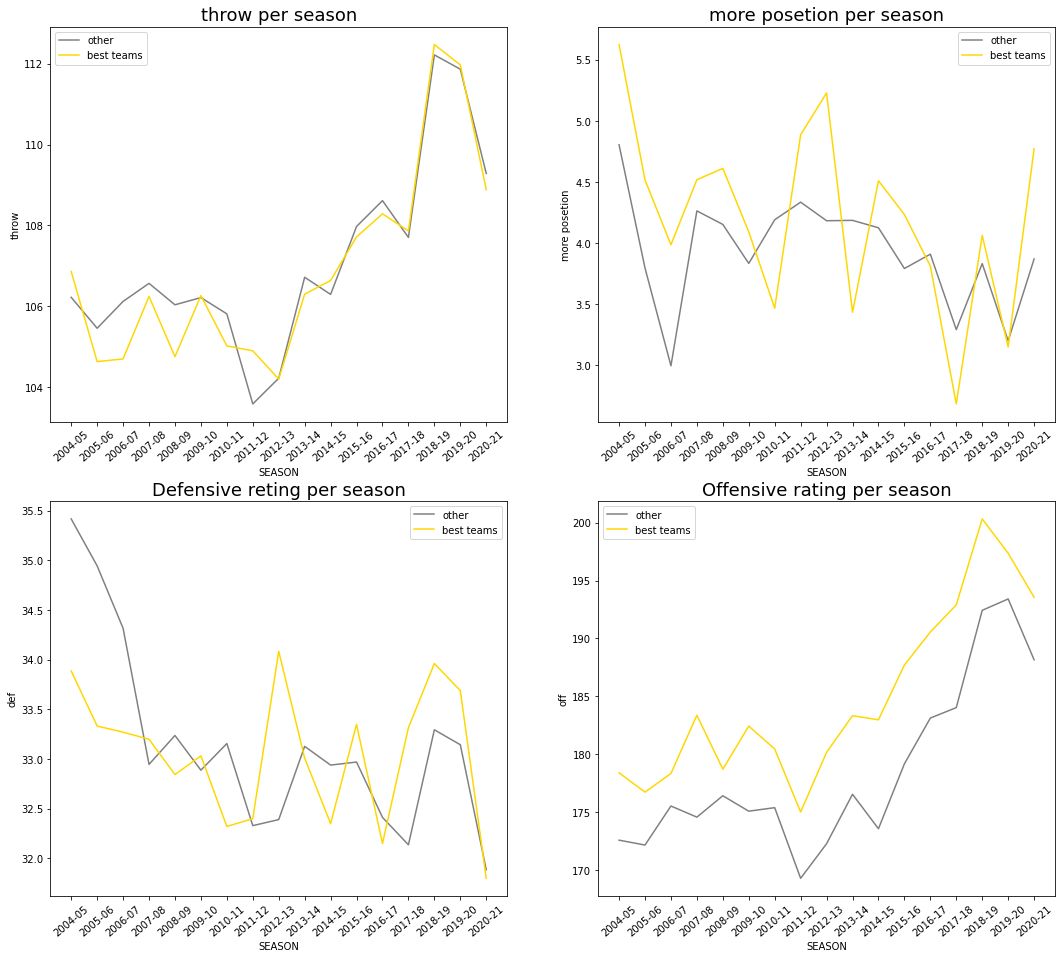

In [60]:
fig, ax= plt.subplots(2,2,figsize=(18,16))
sns.lineplot(data=loser.sort_values('SEASON'),x='SEASON',y='throw',ax=ax[0,0],color='gray',ci=None)
sns.lineplot(data=best_teams.sort_values('SEASON'),x='SEASON',y='throw',ax=ax[0,0],color='gold',ci=None)
ax[0,0].tick_params(axis='x', labelrotation=40)
ax[0,0].set_title("throw per season",fontsize=18)
ax[0,0].legend(['other','best teams'])
sns.lineplot(data=loser.sort_values('SEASON'),x='SEASON',y='more posetion',ax=ax[0,1],color='gray',ci=None)
sns.lineplot(data=best_teams.sort_values('SEASON'),x='SEASON',y='more posetion',ax=ax[0,1],color='gold',ci=None)
ax[0,1].tick_params(axis='x', labelrotation=40)
ax[0,1].set_title("more posetion per season",fontsize=18)
ax[0,1].legend(['other','best teams'])
sns.lineplot(data=loser.sort_values('SEASON'),x='SEASON',y='def',ax=ax[1,0],color='gray',ci=None)
sns.lineplot(data=best_teams.sort_values('SEASON'),x='SEASON',y='def',ax=ax[1,0],color='gold',ci=None)
ax[1,0].tick_params(axis='x', labelrotation=40)
ax[1,0].set_title("Defensive reting per season",fontsize=18)
ax[1,0].legend(['other','best teams'])
sns.lineplot(data=loser.sort_values('SEASON'),x='SEASON',y='off',ax=ax[1,1],color='gray',ci=None)
sns.lineplot(data=best_teams.sort_values('SEASON'),x='SEASON',y='off',ax=ax[1,1],color='gold',ci=None)
ax[1,1].tick_params(axis='x', labelrotation=40)
ax[1,1].set_title("Offensive rating per season",fontsize=18)
ax[1,1].legend(['other','best teams'])
plt.show()

ניתן לראות כי ברבעון העליון של קבוצות הליגה, המדד היחיד שבולט לטובתן הוא המדד ההתקפי. לעומת שאר המדדים האחרים שבהם קבוצות אלה לא בולטות אל מול שאר הליגה.

## predict

ננסה לבנות מודל עבור וושינגטון וויזארדס, לניבוי אחוזי הניצחונות שלה.

בחרנו בקבוצה זו בגלל הנציג הישראלי היחיד בליגה- דני אבדיה.

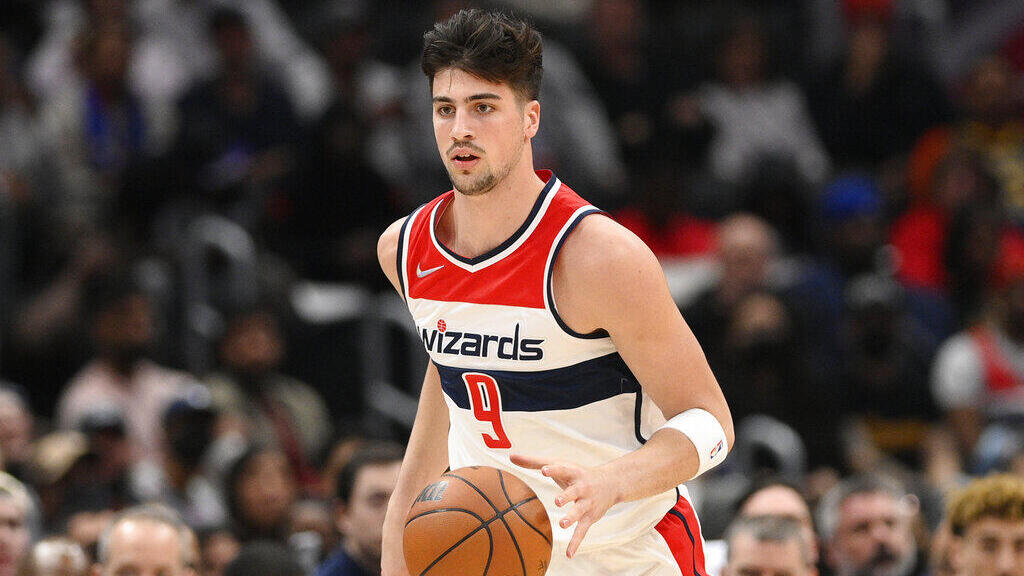

In [61]:
W_W=nba_stat[nba_stat.TEAM=='Washington Wizards']

In [62]:
features = ['off','more posetion'] 
X = W_W[features] 
y = W_W['WIN%'] 

In [63]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.3, random_state=42) 
my_model = DecisionTreeRegressor(max_depth=5,random_state=42)
my_model.fit(X_train, y_train)
prediction = my_model.predict(X_test)

In [64]:
print("Making predictions all the season of Washington Wizards:")
print(y_test)

print("The predictions are")
print(prediction)

print("MSE: {:.3f}".format(mean_squared_error(prediction,y_test,squared=False)))

Making predictions all the season of Washington Wizards:
19     0.462
52     0.347
167    0.500
462    0.512
356    0.317
434    0.500
Name: WIN%, dtype: float64
The predictions are
[0.561      0.39       0.52833333 0.52833333 0.354      0.52833333]
MSE: 0.050


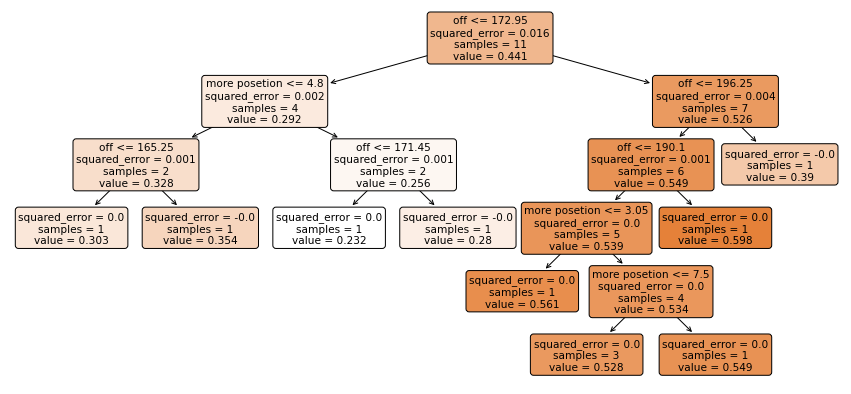

In [67]:
fig = plt.figure(figsize=(15,7))

tree.plot_tree(my_model, 
               feature_names = features, 
               class_names = 'model1.classes_',
               filled=True, 
               rounded = True)  
plt.show()

הצלחנו לבנות מודל לניבוי אחוזי הנצחונות. המודל מנבא על פי המדד ההתקפי, ומדד שסופר יותר פוזישנים לקבוצה. 

על פי מדד הטעות הריבועית הממוצעת למודל קיימת סטייה מדיוק רק של 0.05   

העבודה מוקדשת לקובי בראיינט- השחקן הכי גדול שדרך על הפרקט ונהרג בתאונת מסוק לפני כשנתיים ביחד עם ביתו.